In [47]:
import os
import pandas as pd
import numpy as np
import librosa, librosa.display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import transforms
from sklearn.preprocessing import StandardScaler 

### Identify Relevant Audio Files

In [83]:
meta = pd.read_csv(r'C:\Users\sally\Documents\Fall 2020\CIS 519 - Intro to Machine Learning\Project\audioclassification_meta.csv')
# meta

In [84]:
directory = r'C:\Users\sally\Documents\vox1_dev_wav\wav'
filenames = []
for foldername in os.listdir(directory):
    folder_dir = os.path.join(directory,foldername)
    for subfoldername in os.listdir(folder_dir):
        subfolder_dir = os.path.join(folder_dir,subfoldername)
        for filename in os.listdir(subfolder_dir):
            file = os.path.join(subfolder_dir,filename)
            filenames.append((foldername,file))

In [85]:
files = pd.DataFrame(filenames)
files.rename(columns={0:'ID',1:'file'},inplace=True)

In [86]:
wav_df = meta.merge(files,left_on='VoxCeleb1 ID',right_on='ID')[['ID','Gender','Nationality','file']]

In [87]:
wav_df

,ID,Gender,Nationality,file
0,id10001,m,Ireland,C:\Users\sally\Documents\vox1_dev_wav\wav\id10...
1,id10001,m,Ireland,C:\Users\sally\Documents\vox1_dev_wav\wav\id10...
2,id10001,m,Ireland,C:\Users\sally\Documents\vox1_dev_wav\wav\id10...
3,id10001,m,Ireland,C:\Users\sally\Documents\vox1_dev_wav\wav\id10...
4,id10001,m,Ireland,C:\Users\sally\Documents\vox1_dev_wav\wav\id10...
...,...,...,...,...
148637,id11251,f,USA,C:\Users\sally\Documents\vox1_dev_wav\wav\id11...
148638,id11251,f,USA,C:\Users\sally\Documents\vox1_dev_wav\wav\id11...
148639,id11251,f,USA,C:\Users\sally\Documents\vox1_dev_wav\wav\id11...
148640,id11251,f,USA,C:\Users\sally\Documents\vox1_dev_wav\wav\id11...


In [88]:
# Obtain list of nationalities and count of gender
nationality_gender_count=pd.DataFrame(wav_df.groupby('Nationality')['Gender'].nunique()).reset_index()
nationality_gender_count=nationality_gender_count[nationality_gender_count['Gender'] > 1]['Nationality']

In [89]:
# Keep only nationalities with samples from both genders
wav_df=wav_df.merge(nationality_gender_count,left_on='Nationality',right_on='Nationality')

### Get Samples

In [90]:
# Get list of nationalities
listNat=wav_df['Nationality'].unique()

In [91]:
# Cap samples at 500 max
columns=['ID', 'Gender', 'Nationality','file']
samples = pd.DataFrame(columns=columns)
for i in range(len(listNat)):
    total = wav_df[wav_df['Nationality'] == listNat[i]].count()['ID']
    num = int(0.5 * total)
    if num < 500:
        samp = wav_df[wav_df['Nationality'] == listNat[i]].sample(num,random_state=42)
    else:
        samp = wav_df[wav_df['Nationality'] == listNat[i]].sample(500,random_state=42)
    samples = samples.append(samp)

In [92]:
samples.groupby('Nationality').nunique()

,ID,Gender,Nationality,file
Nationality,,,,
Australia,37,2,1,500
Canada,52,2,1,500
Chile,3,2,1,91
China,2,2,1,188
Croatia,3,2,1,144
Denmark,3,2,1,141
Germany,9,2,1,500
India,25,2,1,500
Ireland,15,2,1,500


In [93]:
samples.groupby('Gender').nunique()

,ID,Gender,Nationality,file
Gender,,,,
f,308,1,20,2672
m,424,1,20,3958


### Feature Extraction

#### Feature Extraction: Helper Functions

In [ ]:
# Filter frequency using FFT
def filter_signal(signal):
    # Take the Fourier transform of the data
    F = np.fft.fft(signal)

    # Filter out any with magnitude < 20
    F_filtered = np.array([0.0 if np.abs(x) < 20 else x for x in F])

    # Reconstruct the filtered signal
    filtered_signal = np.fft.ifft(F_filtered)
    filtered_signal = np.array([float(x) for x in filtered_signal])
    
    return filtered_signal

In [ ]:
def get_spectrogram(file, sr, n_fft, hop_length):
    # Get signal from file
    signal, sampling_rate = librosa.load(file, sr=sr, duration=3)
    
    # Filter out noise
    filt_signal = filter_signal(signal)
    
    # Extract short-time fourier transform
    stft = librosa.core.stft(filt_signal, hop_length=hop_length, n_fft=n_fft)
    
    # Extract log spectrogram
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram) #amplitude as a function of time and frequency
    
    return log_spectrogram

In [ ]:
def get_MFCC(file, n_mfcc):
    # Get signal from file
    signal, sampling_rate = librosa.load(file, duration=3)
    
    # Filter out noise
    filt_signal = filter_signal(signal)
    
    # Extract MFCC
    MFCC = librosa.feature.mfcc(filt_signal, sr=sampling_rate, n_mfcc=n_mfcc)
#     MFCC_processed = np.mean(MFCC.T,axis=0)
    
    return MFCC

In [ ]:
def get_chromagram(file, sr, hop_length):
    # Get signal from file
    signal, sampling_rate = librosa.load(file, duration=3)
    
    # Filter out noise
    filt_signal = filter_signal(signal)
    
    # Extract chromagram
    chromagram = librosa.feature.chroma_stft(filt_signal, sr=sampling_rate, hop_length=hop_length)
    
    return chromagram

In [ ]:
def get_harmonics_percussion(signal):    
    # Get signal from file
    signal, sampling_rate = librosa.load(file,duration=3)
    
    # Filter out noise
    filt_signal = filter_signal(signal)
    
    # Extract short-time fourier transform
    stft = librosa.core.stft(filt_signal)
    
    # Extract harmonics and percussion
    harmonics, percussion = librosa.decompose.hpss(stft)
    harmonics = librosa.amplitude_to_db(np.abs(harmonics))
    percussion = librosa.amplitude_to_db(np.abs(percussion))
    
    return (harmonics, percussion)

In [ ]:
def get_spectral_contrast(signal):    
    # Get signal from file
    signal, sampling_rate = librosa.load(file,duration=3)
    
    # Filter out noise
    filt_signal = filter_signal(signal)
    
    # Extract short-time fourier transform
    stft = librosa.core.stft(filt_signal)
    
    # Extract harmonics and percussion
    spectral = librosa.feature.spectral_contrast(S=stft,sr=sampling_rate)
    spectral_processed = np.mean(spectral.T,axis=0)
    
    return spectral_processed

#### Feature Extraction: Actual Extraction

In [ ]:
# Define features
sr=8000                  # sampling rate
n_fft=2048               # number of samples
hop_length=512           # amount we shift each fourier transfer to the right
n_mfcc=13                # number of MFCCs to extract

In [ ]:
# Obtain labels (as strings)
labels = np.array(samples['Nationality'])
gender = np.array(samples['Gender'])

In [ ]:
# Extract spectrograms to start
features_spectrogram = samples['file'].apply(lambda x: get_spectrogram(x,sr,n_fft,hop_length))

In [ ]:
# Extract MFCCs
features_MFCC = samples['file'].apply(lambda x: get_MFCC(x,n_mfcc))

In [ ]:
# Extract chromagrams
features_chromagram = samples['file'].apply(lambda x: get_chromagram(x,sr,hop_length))

In [ ]:
# Extract harmonics and percussion
features_harm_perc = samples['file'].apply(lambda x: get_harmonics_percussion(x))

features_harm_perc=np.array(features_harm_perc)

harmonics=[]
percussion=[]
for i in range(len(features_harm_perc)):
    harmonics.append(features_harm_perc[i][0])
    percussion.append(features_harm_perc[i][1])

In [ ]:
# Extract spectral contrast
features_spectral = samples['file'].apply(lambda x: get_spectral_contrast(x))

In [ ]:
# Cast spectrogram series into array
arr_features_spectrogram = np.array(features_spectrogram)

# Save spectrograms
np.save('features_spectrogram.npy', arr_features_spectrogram)
np.save('labels.npy', labels)

In [ ]:
# Cast MFCCs series into array
arr_features_MFCCs = np.array(features_MFCC)

# Save MFCCs
# np.save('features_MFCC.npy', arr_features_MFCCs)
# np.save('labels.npy', labels)

np.save('features_MFCC_13_full.npy', arr_features_MFCCs)
np.save('labels_13.npy', labels)

In [ ]:
# Cast chromagram series into array
arr_features_chromagram = np.array(features_chromagram)

# Save MFCCs
np.save('features_chromagram.npy', arr_features_chromagram)
np.save('labels.npy', labels)

In [ ]:
# Cast harmonics and percussion series into array
# arr_features_harm = np.array(harmonics)
# arr_features_perc = np.array(percussion)

# Save MFCCs
np.save('features_harmonics.npy', harmonics)
np.save('features_percussion.npy', percussion)
np.save('labels.npy', labels)

In [ ]:
# Cast spectral contrast series into array
arr_features_spectral = np.array(features_spectral)

# Save spectrograms
np.save('features_spectral.npy', arr_features_spectral)
np.save('labels.npy', labels)

In [ ]:
np.save('labels.npy', labels)

In [ ]:
gender = np.array([0 if x=='m' else 1 for x in gender])
np.save('gender.npy',gender)

### Modeling

#### Load and Manipulate Features

In [2]:
# Reload features when needed
# features_spectrogram=np.load(r'C:\Users\sally\Documents\Fall 2020\CIS 519 - Intro to Machine Learning\Project\features_spectrogram.npy',allow_pickle=True)
features_MFCC=np.load('features_MFCC_40.npy',allow_pickle=True)
features_chromagram=np.load('features_chromagram.npy',allow_pickle=True)
features_harmonics=np.load('features_harmonics_mean.npy',allow_pickle=True)
features_percussion=np.load('features_percussion_mean.npy',allow_pickle=True)
features_spectral=np.load('features_spectral.npy',allow_pickle=True)
labels_str=np.load('labels.npy',allow_pickle=True)
gender=np.load('gender.npy',allow_pickle=True)

In [3]:
# Flatten features
features_chromagram_flattened = []
for i in range(len(features_MFCC)):
    features_chromagram_flattened.append(features_chromagram[i].flatten())

features_chromagram_flattened = np.array(features_chromagram_flattened)

In [4]:
# Combine features
features = []
for i in range(len(features_MFCC)):
    combo = np.append(features_MFCC[i],features_chromagram_flattened[i])
    combo = np.append(combo,features_spectral[i])
    features.append(combo)
    
features=np.array(features)

In [5]:
# Turn labels into numeric values, create dictionary to map back later 
le = preprocessing.LabelEncoder()
le.fit(labels_str)
labels=le.transform(labels_str)

In [6]:
# Cast array to type float64 instead of object for tensors to work
features = [np.array(list(x),dtype=np.float64) for x in features]
features = np.array(features,dtype=np.float64)

labels = [np.long(x) for x in labels]
labels = np.array(labels,dtype=np.long)

#### Split into train and test sets: NORMAL

In [ ]:
# Get train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=142)

#### Split into train and test sets: ZERO-SHOT

In [79]:
features_male = []
labels_male = []
features_female = []
labels_female = []

for i in range(len(gender)):
    if gender[i] == 0:
        features_male.append(features[i])
        labels_male.append(labels[i])
    else:
        features_female.append(features[i])
        labels_female.append(labels[i])
        
features_male = np.array(features_male)
features_female = np.array(features_female)
labels_male = np.array(labels_male)
labels_female = np.array(labels_female)

In [80]:
# Get train and test datasets
X_train, X_val, y_train, y_val = train_test_split(features_male, labels_male, test_size=0.3, random_state=42)
_, X_test, _, y_test = train_test_split(features_female, labels_female, test_size=0.3, random_state=142)

#### Split into train and test sets: Remove Mexico

In [61]:
features_male = []
labels_male = []
features_female = []
labels_female = []

eng_countries=[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]

for i in range(len(gender)):
    if labels[i] in eng_countries:
        if gender[i] == 0:
            features_male.append(features[i])
            labels_male.append(labels[i])
        else:
            features_female.append(features[i])
            labels_female.append(labels[i])
        
features_male = np.array(features_male)
features_female = np.array(features_female)
labels_male = np.array(labels_male)
labels_female = np.array(labels_female)

In [62]:
# Get train and test datasets
X_train, X_val, y_train, y_val = train_test_split(features_male, labels_male, test_size=0.3, random_state=42)
_, X_test, _, y_test = train_test_split(features_female, labels_female, test_size=0.3, random_state=142)

In [63]:
# Turn labels into numeric values, create dictionary to map back later 
lee = preprocessing.LabelEncoder()
lee.fit(labels)
labels_eng = lee.transform(eng_countries)
y_train=lee.transform(y_train)
y_val=lee.transform(y_val)
y_test=lee.transform(y_test)

#### Modeling: Helper Functions

In [9]:
def compute_loss_and_accuracy(network, data_loader):
    total_loss = 0
    num_correct = 0
    num_instances = 0
    predictions_vs_actual = []

    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    for X, y in data_loader:
        with torch.no_grad():
            y_pred = network(X)
            total_loss += cross_entropy_loss(y_pred,y).item() * X.size(0)

        for i in range(len(y_pred)):
            predicted = torch.argmax(y_pred[i])
            actual = y[i]
            predictions_vs_actual.append((predicted,actual))

            if predicted == actual:
                num_correct += 1
                
        num_instances += X.size(0)
  
    accuracy = num_correct / num_instances
    average_loss = total_loss / num_instances

    return accuracy, average_loss, predictions_vs_actual

In [100]:
def run_experiment(network, train_data_loader, valid_data_loader, test_data_loader, optimizer):
    train_losses = []
    train_accs = []
    valid_accs = []

    cross_entropy_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(50):
        print('Epoch: ' + str(epoch))
        total_loss = 0.0
        num_instances = 0

        for X, y in train_data_loader:
            optimizer.zero_grad()
            y_pred = network(X)

            loss = cross_entropy_loss(y_pred,y)
            total_loss+=loss.item() * X.size(0)
            loss.backward()

            optimizer.step()

            num_instances += X.size(0)

        train_loss = total_loss / num_instances
        train_acc, _, _ = compute_loss_and_accuracy(network, train_data_loader)
        valid_acc, valid_loss, _ = compute_loss_and_accuracy(network, valid_data_loader)
        print("Train accuracy: ",train_acc)
        print("Valid accuracy: ",valid_acc)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
    test_acc, _, pred_vs_actual = compute_loss_and_accuracy(network, test_data_loader)
    print("Test accuracy: ",test_acc)
    
    return train_losses, train_accs, valid_accs, pred_vs_actual

#### MFCC Modeling

In [20]:
class Sequential(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(611,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 20),
            nn.ReLU()
        )
    def forward(self, X):
        return self.network(X)

# For English-Speaking Only
# class Sequential(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network=nn.Sequential(
#             nn.Linear(611,256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 6),
#             nn.ReLU()
#         )
#     def forward(self, X):
#         return self.network(X)

In [95]:
# Initialize tensors - Sequential
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)

valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)
valid_data_loader = DataLoader(valid_dataset, batch_size=64)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=64)

In [102]:
network_mfcc = Sequential()
sgd = torch.optim.Adam(network_mfcc.parameters(),lr=0.0001)

train_losses, train_accs, valid_accs, pred_vs_actual = run_experiment(network_mfcc, train_data_loader, valid_data_loader, test_data_loader, sgd)

Epoch: 0
Train accuracy:  0.06714801444043321
Valid accuracy:  0.058922558922558925
Epoch: 1
Train accuracy:  0.07328519855595668
Valid accuracy:  0.06734006734006734
Epoch: 2
Train accuracy:  0.08664259927797834
Valid accuracy:  0.07912457912457913
Epoch: 3
Train accuracy:  0.09422382671480145
Valid accuracy:  0.09427609427609428
Epoch: 4
Train accuracy:  0.0963898916967509
Valid accuracy:  0.09090909090909091
Epoch: 5
Train accuracy:  0.10649819494584838
Valid accuracy:  0.1026936026936027
Epoch: 6
Train accuracy:  0.09963898916967509
Valid accuracy:  0.09090909090909091
Epoch: 7
Train accuracy:  0.1036101083032491
Valid accuracy:  0.09595959595959595
Epoch: 8
Train accuracy:  0.09891696750902527
Valid accuracy:  0.10353535353535354
Epoch: 9
Train accuracy:  0.10974729241877257
Valid accuracy:  0.08585858585858586
Epoch: 10
Train accuracy:  0.10938628158844765
Valid accuracy:  0.10101010101010101
Epoch: 11
Train accuracy:  0.11768953068592057
Valid accuracy:  0.10185185185185185
Epoc

In [22]:
network_mfcc = Sequential()
sgd = torch.optim.Adam(network_mfcc.parameters(), lr=0.0001)

train_losses, train_accs, valid_accs, pred_vs_actual = run_experiment(network_mfcc, train_data_loader, valid_data_loader, test_data_loader, sgd)

Epoch: 0
Train accuracy:  0.0628158844765343
Valid accuracy:  0.06397306397306397
Epoch: 1
Train accuracy:  0.07509025270758123
Valid accuracy:  0.07575757575757576
Epoch: 2
Train accuracy:  0.0776173285198556
Valid accuracy:  0.08585858585858586
Epoch: 3
Train accuracy:  0.08916967509025271
Valid accuracy:  0.09006734006734007
Epoch: 4
Train accuracy:  0.10288808664259928
Valid accuracy:  0.09764309764309764
Epoch: 5
Train accuracy:  0.10180505415162455
Valid accuracy:  0.09343434343434344
Epoch: 6
Train accuracy:  0.10722021660649819
Valid accuracy:  0.117003367003367
Epoch: 7
Train accuracy:  0.10108303249097472
Valid accuracy:  0.09848484848484848
Epoch: 8
Train accuracy:  0.11624548736462094
Valid accuracy:  0.10942760942760943
Epoch: 9
Train accuracy:  0.11732851985559567
Valid accuracy:  0.1026936026936027
Epoch: 10
Train accuracy:  0.11407942238267148
Valid accuracy:  0.1111111111111111
Epoch: 11
Train accuracy:  0.11010830324909747
Valid accuracy:  0.11026936026936027
Epoch: 1

Train accuracy:  0.34115523465703973
Valid accuracy:  0.2138047138047138
Test accuracy:  0.09351620947630923


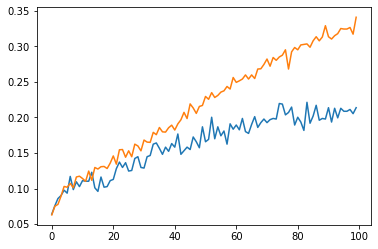

In [23]:
plt.plot(valid_accs)
plt.plot(train_accs)

#### Test Removing Mexico

In [72]:
# Initialize tensors - Sequential
X_train_tensor_mex = torch.tensor(X_train, dtype=torch.float)
y_train_tensor_mex = torch.tensor(y_train, dtype=torch.long)

X_val_tensor_mex = torch.tensor(X_val, dtype=torch.float)
y_val_tensor_mex = torch.tensor(y_val, dtype=torch.long)

X_test_tensor_mex = torch.tensor(X_test, dtype=torch.float)
y_test_tensor_mex = torch.tensor(y_test, dtype=torch.long)


train_dataset_mex = TensorDataset(X_train_tensor_mex, y_train_tensor_mex)
train_data_loader_mex = DataLoader(train_dataset_mex, batch_size=64,shuffle=True)

valid_dataset_mex = TensorDataset(X_val_tensor_mex, y_val_tensor_mex)
valid_data_loader_mex = DataLoader(valid_dataset_mex, batch_size=64)

test_dataset_mex = TensorDataset(X_test_tensor_mex, y_test_tensor_mex)
test_data_loader_mex = DataLoader(test_dataset_mex, batch_size=64)

In [78]:
network_mfcc = Sequential()
sgd = torch.optim.Adam(network_mfcc.parameters(), lr=0.00001)

train_losses, train_accs, valid_accs, pred_vs_actual = run_experiment(network_mfcc, train_data_loader_mex, valid_data_loader_mex, test_data_loader_mex, sgd)

Epoch: 0
Train accuracy:  0.06921606118546846
Valid accuracy:  0.0767172167707404
Epoch: 1
Train accuracy:  0.08298279158699809
Valid accuracy:  0.08563782337198929
Epoch: 2
Train accuracy:  0.09254302103250478
Valid accuracy:  0.08563782337198929
Epoch: 3
Train accuracy:  0.08183556405353729
Valid accuracy:  0.09634255129348795
Epoch: 4
Train accuracy:  0.10133843212237094
Valid accuracy:  0.10258697591436218
Epoch: 5
Train accuracy:  0.102868068833652
Valid accuracy:  0.11507582515611062
Epoch: 6
Train accuracy:  0.12084130019120459
Valid accuracy:  0.11953612845673506
Epoch: 7
Train accuracy:  0.11089866156787763
Valid accuracy:  0.10883140053523639
Epoch: 8
Train accuracy:  0.1158699808795411
Valid accuracy:  0.11685994647636039
Epoch: 9
Train accuracy:  0.12925430210325048
Valid accuracy:  0.10704727921498662
Epoch: 10
Train accuracy:  0.12466539196940726
Valid accuracy:  0.11061552185548618
Epoch: 11
Train accuracy:  0.12619502868068833
Valid accuracy:  0.11239964317573595
Epoch:

Train accuracy:  0.3476099426386233
Valid accuracy:  0.20071364852809992
Test accuracy:  0.10252996005326231


In [66]:
arr_pred_vs_actual = []
for i in range(len(pred_vs_actual)):
    pred = np.int(pred_vs_actual[i][0])
    actual = np.int(pred_vs_actual[i][1])
    arr_pred_vs_actual.append([pred,actual])

In [67]:
pred_vs_actual_df = pd.DataFrame(arr_pred_vs_actual)
pred_vs_actual_df.rename(columns={0:'Prediction',1:'Actual'},inplace=True)

In [68]:
pred_vs_actual_df['Correct'] = pred_vs_actual_df['Prediction'] - pred_vs_actual_df['Actual']
pred_vs_actual_df['Correct'] = pred_vs_actual_df['Correct'].apply(lambda x: 1 if x==0 else 0)

In [70]:
labels_encoded=np.array(list(set(labels_eng)))
labels_classes=le.inverse_transform(lee.inverse_transform(labels_encoded))

labels_mapping = []
for x,y in zip(labels_encoded,labels_classes):
    labels_mapping.append([x,y])

labels_mapping = pd.DataFrame(labels_mapping)

In [71]:
pred_vs_actual_df=pred_vs_actual_df.merge(labels_mapping,left_on='Prediction',right_on=0).drop(columns={0}).rename(columns={1:'Pred_Country'})\
                 .merge(labels_mapping,left_on='Actual',right_on=0).drop(columns={0}).rename(columns={1:'Actual_Country'})

pred_vs_actual_df[pred_vs_actual_df.Correct == 0].groupby(['Pred_Country','Actual_Country']).count().sort_values('Correct',ascending=False).reset_index()

,Pred_Country,Actual_Country,Prediction,Actual,Correct
0,Canada,Sweden,18,18,18
1,USA,Sweden,16,16,16
2,India,Germany,15,15,15
3,USA,Canada,15,15,15
4,Norway,Germany,15,15,15
5,Canada,USA,14,14,14
6,USA,India,13,13,13
7,Canada,India,13,13,13
8,Canada,Italy,12,12,12
9,India,Canada,11,11,11


#### Investigate Differences

In [24]:
arr_pred_vs_actual = []
for i in range(len(pred_vs_actual)):
    pred = np.int(pred_vs_actual[i][0])
    actual = np.int(pred_vs_actual[i][1])
    arr_pred_vs_actual.append([pred,actual])

In [25]:
pred_vs_actual_df = pd.DataFrame(arr_pred_vs_actual)
pred_vs_actual_df.rename(columns={0:'Prediction',1:'Actual'},inplace=True)

In [26]:
pred_vs_actual_df['Correct'] = pred_vs_actual_df['Prediction'] - pred_vs_actual_df['Actual']

In [27]:
pred_vs_actual_df['Correct'] = pred_vs_actual_df['Correct'].apply(lambda x: 1 if x==0 else 0)

In [28]:
# For normal zero-shot only
labels_encoded=np.array(list(set(labels)))
labels_classes=le.inverse_transform(labels_encoded)

In [ ]:
# For English-speaking only
# labels_encoded=np.array(list(set(labels_eng)))
# labels_classes=le.inverse_transform(lee.inverse_transform(labels_encoded))

In [29]:
labels_mapping = []
for x,y in zip(labels_encoded,labels_classes):
    labels_mapping.append([x,y])

labels_mapping = pd.DataFrame(labels_mapping)

In [30]:
pred_vs_actual_df=pred_vs_actual_df.merge(labels_mapping,left_on='Prediction',right_on=0).drop(columns={0}).rename(columns={1:'Pred_Country'})\
                 .merge(labels_mapping,left_on='Actual',right_on=0).drop(columns={0}).rename(columns={1:'Actual_Country'})

In [38]:
pd.set_option('display.max_rows', 500)
pred_vs_actual_df[pred_vs_actual_df.Correct == 0].groupby(['Pred_Country','Actual_Country']).count().sort_values('Correct',ascending=False).reset_index()

,Pred_Country,Actual_Country,Prediction,Actual,Correct
0,Mexico,Germany,27,27,27
1,Mexico,Sweden,27,27,27
2,Mexico,India,23,23,23
3,Mexico,USA,22,22,22
4,Mexico,Canada,20,20,20
5,Mexico,Norway,18,18,18
6,Mexico,Philippines,17,17,17
7,Mexico,UK,17,17,17
8,Mexico,Italy,15,15,15
9,Norway,Germany,12,12,12


In [54]:
mexico = pred_vs_actual_df[pred_vs_actual_df.Correct == 0].groupby(['Pred_Country','Actual_Country']).count().sort_values('Correct',ascending=False).reset_index()

mexico = mexico[mexico.eval("Pred_Country == 'Mexico' | Actual_Country =='Mexico'")]

sum(mexico['Correct'])

281

In [56]:
sum(pred_vs_actual_df[pred_vs_actual_df.Correct == 0].groupby(['Pred_Country','Actual_Country']).count().sort_values('Correct',ascending=False).reset_index()['Correct'])

727

#### Spectogram: IGNORE UNUSED

In [ ]:
class Convolutional(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=10,kernel_size=2,stride=1,padding=0)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc1 = torch.nn.Linear(in_features=32*2*11,out_features=100)
        self.drop1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(in_features=100,out_features=50)
        self.drop2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(in_features=50,out_features=20)


    def forward(self, X):
        batch_size = 64
        X = self.conv1(X)
        X = self.pool1(X)
        X = self.conv2(X)
        X = self.pool2(X)
        X = X.relu()
        X = X.view(batch_size, -1)
        X = self.fc1(X)
        X - self.drop1(X)
        X = X.relu()
        X = self.fc2(X)
        X - self.drop2(X)
        X = X.relu()
        X = self.fc3(X)

        return X

In [ ]:
# class Sequential(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network=nn.Sequential(
#             nn.Linear(40,128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512,64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64,20),
#             nn.Tanh()
#         )
#     def forward(self, X):
#         return self.network(X)

In [ ]:
# Initialize tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_train_tensor = X_train_tensor.reshape([X_train.shape[0],1,X_train.shape[1],X_train.shape[2]])
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
X_test_tensor = X_test_tensor.reshape([X_test.shape[0],1,X_test.shape[1],X_test.shape[2]])
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)

valid_dataset = TensorDataset(X_test_tensor, y_test_tensor)
valid_data_loader = DataLoader(valid_dataset, batch_size=64)

In [ ]:
network = Convolutional()
sgd = torch.optim.SGD(network.parameters(), lr=0.001)

train_losses, valid_accs = run_experiment(network, train_data_loader, valid_data_loader, sgd)

In [ ]:
# Randomly drop some to make batch sizes even
# drop = random.sample(range(0,X_train.shape[0]),4608)
# X_train=X_train[list(drop)]
# y_train=y_train[list(drop)]

# drop = random.sample(range(0,X_test.shape[0]),1984)
# X_test=X_test[list(drop)]
# y_test=y_test[list(drop)]

#### Unused Section: Leave just in case

In [ ]:
# Unused
def extract_features(signal, sr, n_fft, hop_length, n_mfcc):    
    # Extract short-time fourier transform
    stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
    
    # Extract log spectrogram
    log_spectrogram = extract_spectrogram(stft)
    
    # Extract MFCC
    MFCC = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
    # Extract chromagram
    chromagram = librosa.feature.chroma_stft(signal, sr=sr, hop_length=hop_length)
    
    # Extract harmonics and percussion
    harmonics, percussion = extract_harmonics_percussion(stft)
    
    return log_spectrogram, MFCC, chromagram, harmonics, percussion

In [ ]:
def extract_harmonics_percussion(stft):
    harm, perc = librosa.decompose.hpss(stft)
    harm = librosa.amplitude_to_db(np.abs(harm))
    perc = librosa.amplitude_to_db(np.abs(perc))
    
    return harm, perc